# AMS 560 Project: AlphaTrader

Zhuming Shi

## How to run this code

1. Install following libs:

- gymnasium
- stable_baselines3
- pandas
- numpy
- matplotlib
- re

2. Run this notebook till the last part on VS Code or Jupyter notebook

3. Export the output of render to a file, in example, 'result.txt', and then run the last plot part

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
from typing import Optional

In [ ]:
INIT_ACCOUNT_BALANCE = 10000

MAX_ACCOUNT_BALANCE = 1000000
MAX_NUM_SHARES = 1000
MAX_SHARE_PRICE = 300
MAX_VOLUME = 400000000

ACTION_BUY = 1
ACTION_SELL = 2
ACTION_HOLD = 3

In [94]:
# formalize the data

# "Date","Price","Open","High","Low","Vol.","Change %"
# "02/12/2024","239.59","237.27","240.79","237.16","48.14M","0.95%"

def formalize_data(file_name: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(file_name)
    # convert "48.14M" to 48140000
    df["Vol."] = df["Vol."].apply(lambda x: float(x[:-1]) * 1000000 if x[-1] == "M" else float(x))
    # convert "02/12/2024" to 20241202
    df["Date"] = df["Date"].apply(lambda x: int(x[-4:] + x[3:5] + x[:2]))
    # resort according to date
    df = df.sort_values("Date")
    # # normalize the data
    # df["Price"] = df["Price"] / MAX_SHARE_PRICE
    # df["Open"] = df["Open"] / MAX_SHARE_PRICE
    # df["High"] = df["High"] / MAX_SHARE_PRICE
    # df["Low"] = df["Low"] / MAX_SHARE_PRICE
    # df["Vol."] = df["Vol."] / MAX_VOLUME
    # divide the data into training and testing, 80% and 20%
    split = int(len(df) * 0.8)
    train_df = df.iloc[:split]
    test_df = df.iloc[split:]
    # reset the index
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    return train_df, test_df


# test the function
train_df, test_df = formalize_data("data/AAPLHistoricalData.csv")
print(train_df.size)
print(test_df.size)
print(train_df.loc[0, "Price"])


1512
385
176.65


In [154]:
# Build the trading environment

# Features:
# self.data: historical data, self.data[step, 'Price']
# self.window_size
# self.n_samples
# self.action_space
# self.observation_space

# Status:
# self.current_step
# self.balance
# self.shares_held
# self.total_buy_cost
# self.total_sell_return
# self.shares_value = self.data[self.current_step, 'Price'] * self.shares_held
# self.net_worth = self.balance + self.shares_value
# self.cost_basis = (self.total_buy_cost - self.total_sell_return)/self.shares_held


class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, data: pd.DataFrame, window_size: int, render_mode='human'):
        self.render_mode = render_mode
        super(TradingEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        # 7 colums in dataframe
        self.n_samples = len(data)
        print(self.n_samples)
        # Action Space:
        # action[0] = 0-1:buy/1-2:sell/2-3:hold, action[1] = fraction of shares to buy/sell
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)
        # Observation Space:
        # observation space is normalized to 0-1, including balance, net_worth,  shares_held, cost_basis, shares_value,
        # and today - window_size to today's Price, Open, High, Low, Vol. (windows_size + 1 days)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6, self.window_size + 1), dtype=np.float32)
        self.act = 'Buy'
        self.frac = 0
        self.reset()

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = INIT_ACCOUNT_BALANCE
        self.shares_held = 0
        self.done = False
        self.total_sell_return = 0
        self.total_buy_cost = 0
        self.net_worth = INIT_ACCOUNT_BALANCE
        self.cost_basis = 0
        self.shares_value = 0
        self._update_state()
        return self.state, {}

    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        print(self.current_step, self.n_samples)
        if self.current_step >= self.n_samples - 2:
            self.done = True
        self._update_state()
        reward = self.net_worth - self.balance
        return self.state, reward, self.done, False, {}
    
    def render(self):
        print(f'Date: {self.data.loc[self.current_step, "Date"]}')
        print(f'Step: {self.current_step}')
        print(f'Action: {self.act} {self.frac}')
        print(f'Price: {self.data.loc[self.current_step, "Price"]}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held}')
        print(
            f'Avg cost for held shares: {self.cost_basis} ')
        print(
            f'Net worth: {self.net_worth}')
        print(f'Profit: {self.net_worth - INIT_ACCOUNT_BALANCE}')

    def _take_action(self, action: int):
        if action[0] <= ACTION_BUY:
            self._buy_asset(action[1])
        elif action[0] <= ACTION_SELL:
            self._sell_asset(action[1])
        else:
            self._hold()

    # asset fraction of balance to shares, need to calculate number of shares
    def _buy_asset(self, asset):
        asset_price = self.data.loc[self.current_step, 'Price']
        cost = asset * self.balance
        num_shares = cost / asset_price
        self.balance -= cost
        self.shares_held += num_shares
        self.total_buy_cost += cost
        self.act = 'Buy'
        self.frac = asset

    # asset fraction of shares to balance, need to calculate number of shares
    def _sell_asset(self, asset):
        asset_price = self.data.loc[self.current_step, 'Price']
        num_shares = asset * self.shares_held
        ret = num_shares * asset_price
        self.balance += ret
        self.shares_held -= num_shares
        self.total_sell_return += ret
        self.act = 'Sell'
        self.frac = asset

    def _hold(self):
        self.act = 'Hold'
        self.frac = 0

    def _update_state(self):
        # print(self.current_step, self.data.loc[self.current_step, 'Date'], self.net_worth, self.balance, self.shares_held)
        self.shares_value = self.data.loc[self.current_step, 'Price'] * self.shares_held
        self.net_worth = self.balance + self.shares_value
        if self.shares_held != 0:
            self.cost_basis = (self.total_buy_cost - self.total_sell_return)/self.shares_held
        else:
            self.cost_basis = 0
        self.state = np.array([
            self.balance / MAX_ACCOUNT_BALANCE,
            self.net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.shares_value / MAX_ACCOUNT_BALANCE
        ])
        self.state = np.append(self.state, [0] * (self.window_size - 4))
        self.state = np.vstack([self.state,
                self.data.loc[self.current_step - self.window_size:self.current_step, 'Price']/MAX_SHARE_PRICE,
                self.data.loc[self.current_step - self.window_size:self.current_step, 'Open']/MAX_SHARE_PRICE,
                self.data.loc[self.current_step - self.window_size:self.current_step, 'High']/MAX_SHARE_PRICE,
                self.data.loc[self.current_step - self.window_size:self.current_step, 'Low']/MAX_SHARE_PRICE,
                self.data.loc[self.current_step - self.window_size:self.current_step, 'Vol.']/MAX_VOLUME])
        
        # transfer self.state to float32
        self.state = self.state.astype(np.float32)

from stable_baselines3.common.env_checker import check_env
check_env(TradingEnv(train_df, 10))

216
11 216
11 216
12 216
13 216
14 216
15 216
16 216
17 216
18 216
19 216
20 216


In [155]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

window_size = 10

train_df, test_df = formalize_data("data/AAPLHistoricalData.csv")
env = DummyVecEnv([lambda: TradingEnv(train_df, window_size)])
# print(train_df.size)
# print(train_df)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(20000)

216
Using cpu device
11 216
12 216
13 216
14 216
15 216
16 216
17 216
18 216
19 216
20 216
21 216
22 216
23 216
24 216
25 216
26 216
27 216
28 216
29 216
30 216
31 216
32 216
33 216
34 216
35 216
36 216
37 216
38 216
39 216
40 216
41 216
42 216
43 216
44 216
45 216
46 216
47 216
48 216
49 216
50 216
51 216
52 216
53 216
54 216
55 216
56 216
57 216
58 216
59 216
60 216
61 216
62 216
63 216
64 216
65 216
66 216
67 216
68 216
69 216
70 216
71 216
72 216
73 216
74 216
75 216
76 216
77 216
78 216
79 216
80 216
81 216
82 216
83 216
84 216
85 216
86 216
87 216
88 216
89 216
90 216
91 216
92 216
93 216
94 216
95 216
96 216
97 216
98 216
99 216
100 216
101 216
102 216
103 216
104 216
105 216
106 216
107 216
108 216
109 216
110 216
111 216
112 216
113 216
114 216
115 216
116 216
117 216
118 216
119 216
120 216
121 216
122 216
123 216
124 216
125 216
126 216
127 216
128 216
129 216
130 216
131 216
132 216
133 216
134 216
135 216
136 216
137 216
138 216
139 216
140 216
141 216
142 216
143 216
144 

In [164]:
# Create a new environment with the test data
test_env = DummyVecEnv([lambda: TradingEnv(test_df, window_size)])

# Reset the environment
obs = test_env.reset()

# Run the model on the test environment
for i in range(len(test_df) - window_size - 3):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()

55
11 55
Date: 20241001
Step: 11
Action: Buy 0.0
Price: 226.21
Balance: 10000.0
Shares held: 0.0
Avg cost for held shares: 0 
Net worth: 10000.0
Profit: 0.0
12 55
Date: 20241002
Step: 12
Action: Buy 1.0
Price: 226.78
Balance: 0.0
Shares held: 44.20671057866584
Avg cost for held shares: 226.21 
Net worth: 10025.19782502984
Profit: 25.197825029839805
13 55
Date: 20241003
Step: 13
Action: Sell 0.0
Price: 225.67
Balance: 0.0
Shares held: 44.20671057866584
Avg cost for held shares: 226.21 
Net worth: 9976.12837628752
Profit: -23.87162371248087
14 55
Date: 20241004
Step: 14
Action: Hold 0
Price: 226.8
Balance: 0.0
Shares held: 44.20671057866584
Avg cost for held shares: 226.21 
Net worth: 10026.081959241414
Profit: 26.081959241413642
15 55
Date: 20241007
Step: 15
Action: Sell 0.22509346902370453
Price: 221.69
Balance: 2256.80556892163
Shares held: 34.25606874038705
Avg cost for held shares: 226.03861785077916 
Net worth: 9851.033447978036
Profit: -148.96655202196416
16 55
Date: 20241008
Step

       Date       Balance  Shares held    Avg cost     Net worth     Profits
0  20241001  10000.000000          0.0    0.000000  10000.000000    0.000000
1  20241002      0.000000         44.0  226.210007  10025.198242   25.197824
2  20241003      0.000000         44.0  226.210007   9976.127930  -23.871624
3  20241004      0.000000         44.0  226.210007  10026.082031   26.081959
4  20241007   2256.805664         34.0  226.038620   9851.033203 -148.966553


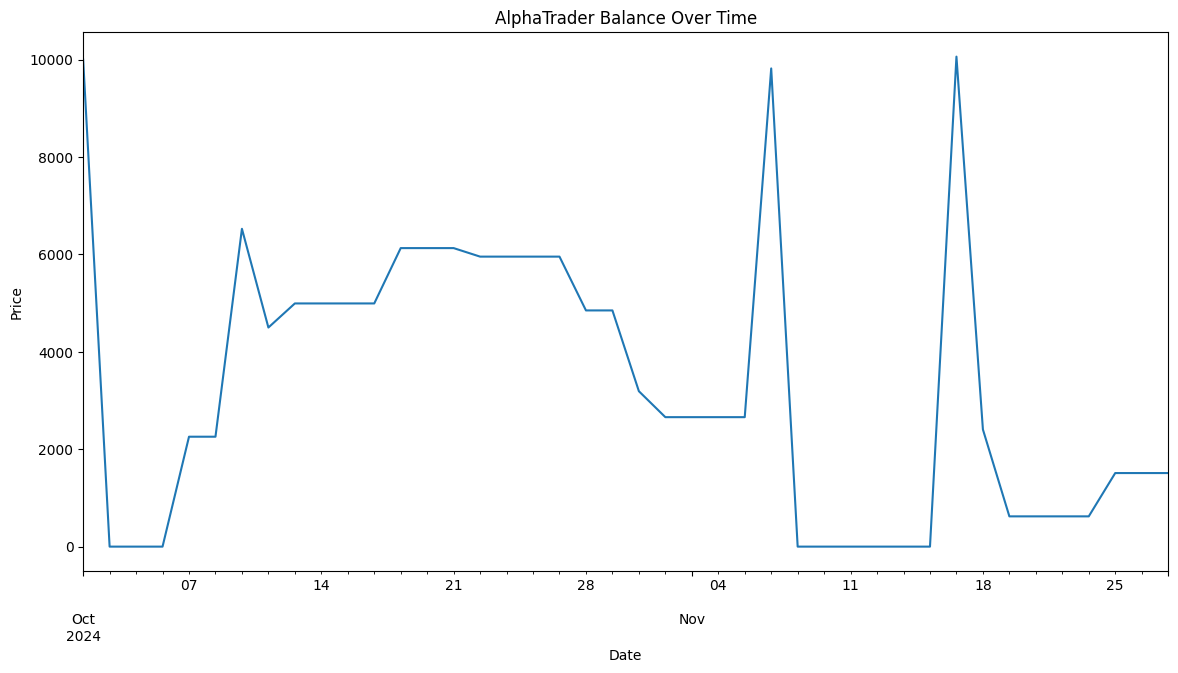

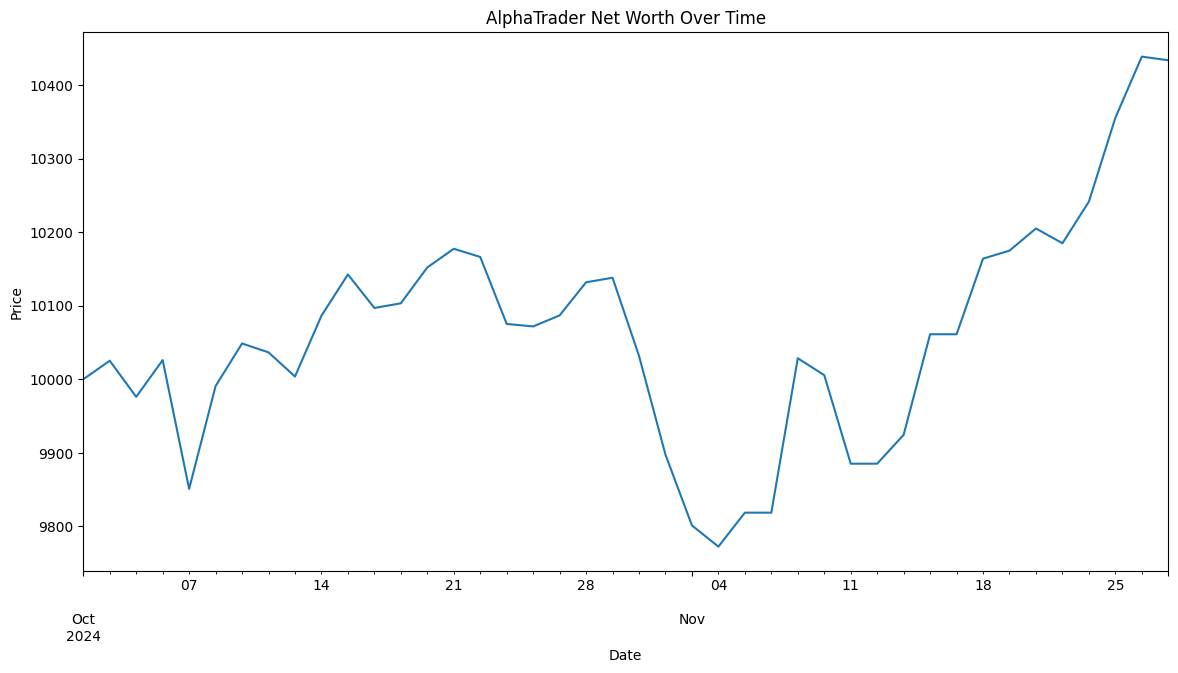

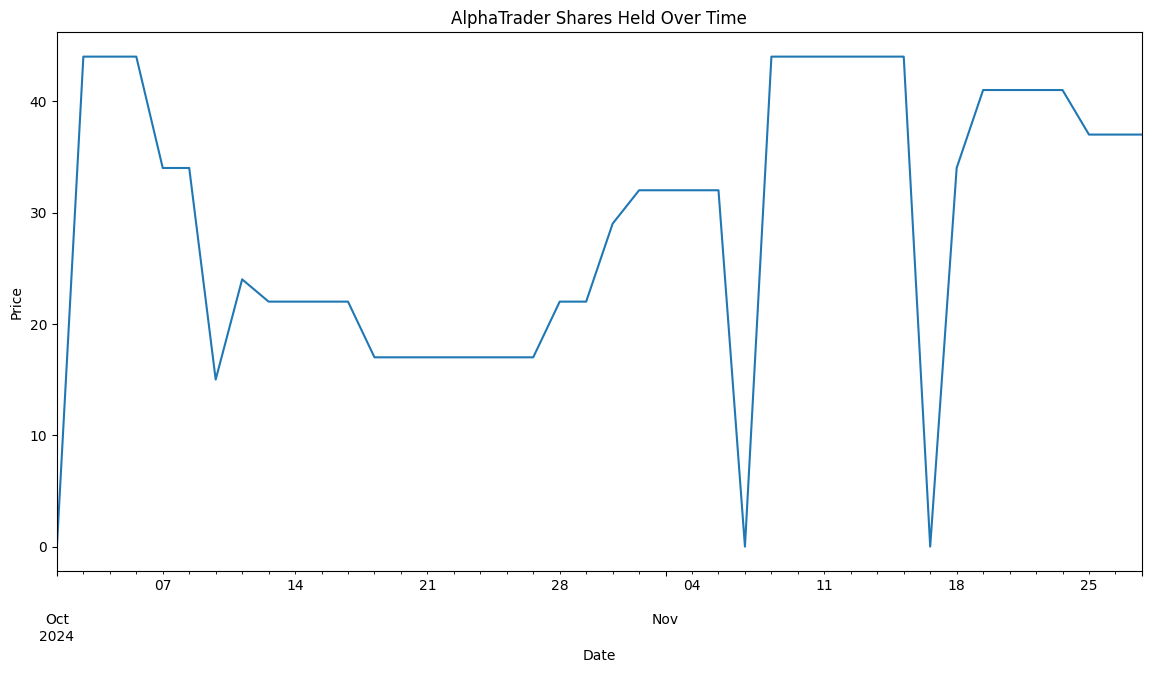

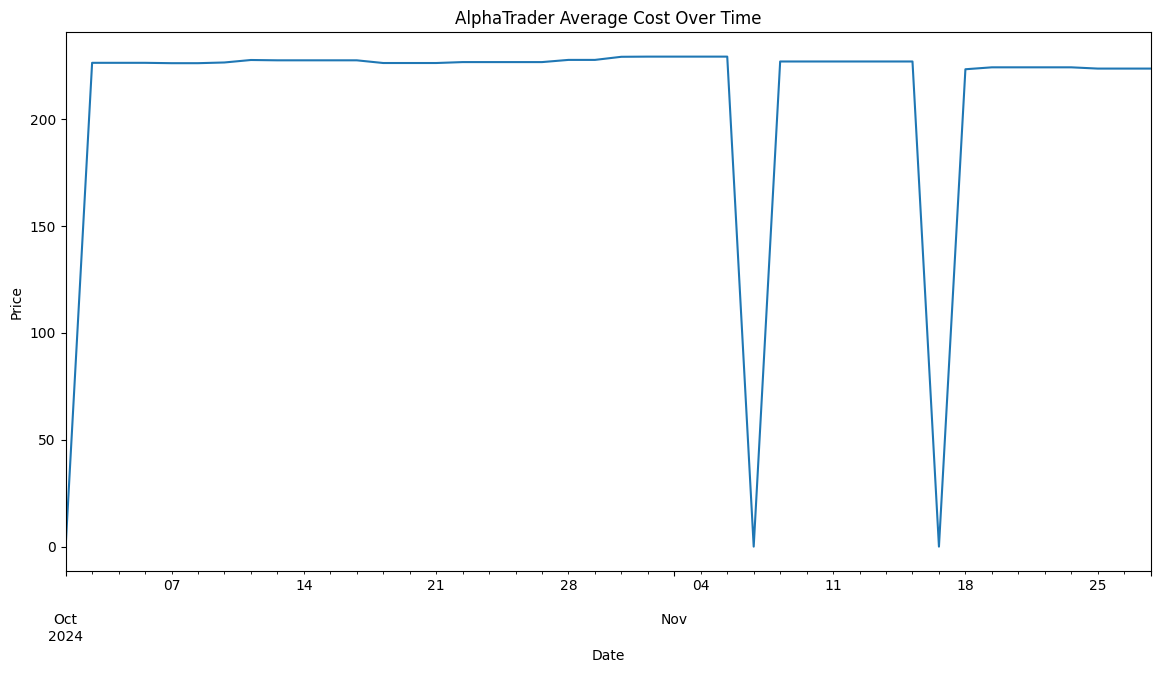

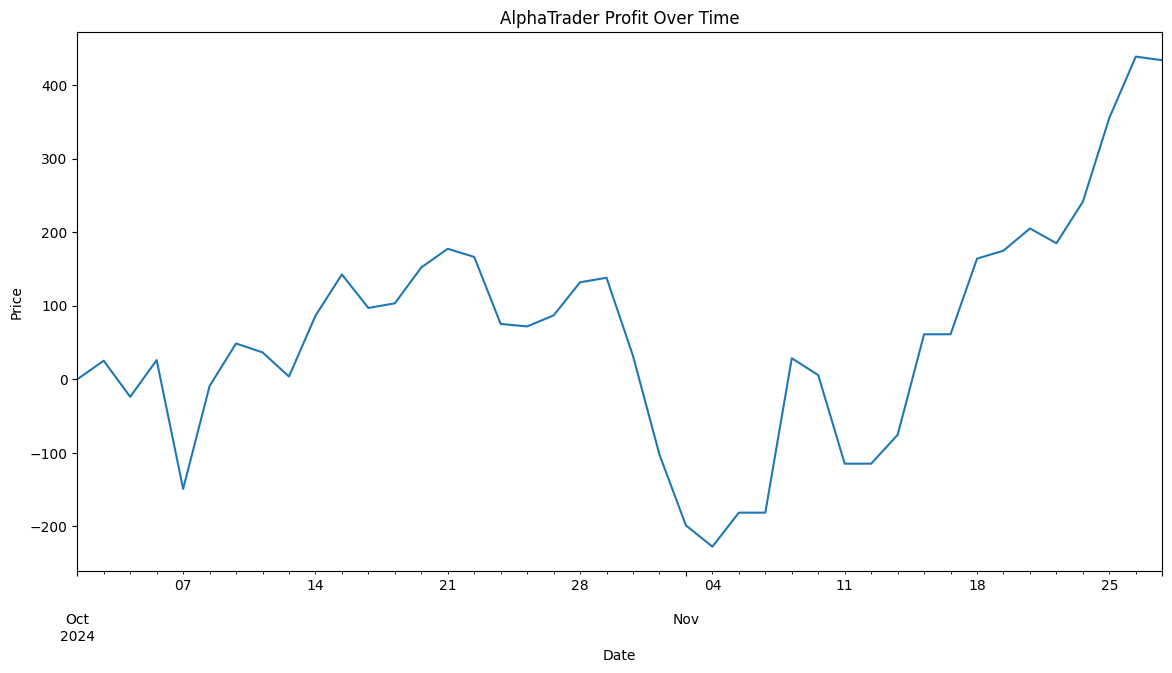

In [180]:
import re

import matplotlib.pyplot as plt

# 读取文件内容
with open('result.txt', 'r') as file:
    data = file.read()

date = re.findall(r'Date: (\d+)', data)
balances = re.findall(r'Balance: ([\d.]+)', data)
shares_held = re.findall(r'Shares held: (\d+)', data)
avg_cost = re.findall(r'Avg cost for held shares: ([\d.]+)', data)
net_worth = re.findall(r'Net worth: ([\d.]+)', data)
profits = re.findall(r'Profit: ([\d.-]+)', data)

# 将数据转换为DataFrame
df = pd.DataFrame({
    'Date': date,
    'Balance': balances,
    'Shares held': shares_held,
    'Avg cost': avg_cost,
    'Net worth': net_worth,
    'Profits': profits
})

# modify 'Balance', 'Shares held', 'Avg cost', 'Net worth', 'Profits' to np.float32
df['Balance'] = df['Balance'].astype(np.float32)
df['Shares held'] = df['Shares held'].astype(np.float32)
df['Avg cost'] = df['Avg cost'].astype(np.float32)
df['Net worth'] = df['Net worth'].astype(np.float32)
df['Profits'] = df['Profits'].astype(np.float32)

print(df.head())

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)
df['Balance'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AlphaTrader Balance Over Time')
plt.show()

df['Net worth'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AlphaTrader Net Worth Over Time')
plt.show()

df['Shares held'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AlphaTrader Shares Held Over Time')
plt.show()

df['Avg cost'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AlphaTrader Average Cost Over Time')
plt.show()

df['Profits'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AlphaTrader Profit Over Time')
plt.show()